In [73]:
import json
import os
import faiss
from sentence_transformers import SentenceTransformer, CrossEncoder
from transformers import pipeline

CONTENT_LIST_PATHS = [
    "C:/Coding/VSCode/chatbot/output/abus_elektro-seilzug_programm/auto/abus_elektro-seilzug_programm_content_list.json",
    "C:/Coding/VSCode/chatbot/output/abus_hb-system_programm/auto/abus_hb-system_programm_content_list.json",
    "C:/Coding/VSCode/chatbot/output/abus_laufkran_programm/auto/abus_laufkran_programm_content_list.json"
]
IMAGES_BASE_DIRS = [
    "C:/Coding/VSCode/chatbot/output/abus_elektro-seilzug_programm/auto/images",
    "C:/Coding/VSCode/chatbot/output/abus_hb-system_programm/auto/images",
    "C:/Coding/VSCode/chatbot/output/abus_laufkran_programm/auto/images"
]

# Function to load JSON content from the given paths
def load_content(paths):
    """Load JSON content from the given paths."""
    content = []
    for path in paths:
        try:
            with open(path, "r", encoding="utf-8") as file:
                content.extend(json.load(file))
        except Exception as e:
            print(f"Error loading {path}: {e}")
    return content

# Function to extract texts, page indexes, and image paths from the content list
def extract_content(content_list, image_dirs):
    """Extract texts, page indexes, and image paths from the content list."""
    texts, page_indexes, image_paths = [], [], []
    image_dir_mapping = {os.path.basename(dir): dir for dir in image_dirs}

    for item in content_list:
        if item["type"] == "text" and item["text"].strip():
            texts.append(item["text"].strip())
            image_paths.append(None)
        elif item["type"] == "image":
            caption = " ".join(item.get("img_caption", [])).strip() or "No caption available"
            texts.append(caption)
            img_dir = os.path.dirname(item["img_path"])
            base_dir = image_dir_mapping.get(os.path.basename(img_dir), image_dirs[0])
            image_paths.append(os.path.normpath(os.path.join(base_dir, item["img_path"])))
    return texts, image_paths

# Function to initialize and return a FAISS index with the given embeddings
def initialize_faiss_index(embeddings):
    """Initialize and return a FAISS index with the given embeddings."""
    embedding_dim = embeddings.shape[1]
    index = faiss.IndexFlatIP(embedding_dim)
    index.add(embeddings)
    return index

# Function to search for the query and return an answer or relevant context
def search_and_answer(query, k=5, confidence_threshold=0.01):
    """Searches for relevant information based on the provided query, retrieves and ranks the top results,
    and generates an answer using a question-answering (QA) model."""
    print("-" * 50)
    print(f"\nSearching for: {query}, retrieving top {k * 2} results")
    
    # Encode the query and search the FAISS index
    query_embedding = embedding_model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    distances, indices = index.search(query_embedding, k * 2)
    
    # Retrieve texts
    retrieved_texts = [texts[idx] for idx in indices[0] if idx < len(texts)]
    
    # Rank texts using the reranker
    pairs = [[query, text] for text in retrieved_texts]
    scores = reranker.predict(pairs)
    sorted_texts = [text for _, text in sorted(zip(scores, retrieved_texts), reverse=True)[:k]]
    context = " ".join(sorted_texts)

    # Print retrieved and ranked texts for debugging
    print("\nRetrieved texts:")
    for text in retrieved_texts:
        print(f"- {text}")
    print("\nRanked texts:")
    for text in sorted_texts:
        print(f"- {text}")
    print(f"\nUsing context: {context}\n")
    print("-" * 50)
    print(f"\nQuery: {query}")

    # Get the answer from the QA model
    result = qa_model(question=query, context=context)
    if result.get('score', 0) < confidence_threshold:
        print("Model is unsure about the answer. Returning context instead.")
        return context
    else:
        print(f"Answer: {result['answer']}")
        return result['answer']
    
# Load content
content_list = load_content(CONTENT_LIST_PATHS)
print(f"Loaded {len(content_list)} items from JSON.")

# Extract texts and image paths
texts, image_paths = extract_content(content_list, IMAGES_BASE_DIRS)
print(f"Extracted {len(texts)} texts and {len([p for p in image_paths if p])} images.")

# Initialize models
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
embeddings = embedding_model.encode(texts, convert_to_numpy=True, normalize_embeddings=True)
print(f"Computed embeddings shape: {embeddings.shape}")

reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
qa_model = pipeline("question-answering", model="deepset/gelectra-base-germanquad")
print("Models loaded successfully.")

# Initialize FAISS index
index = initialize_faiss_index(embeddings)
print(f"FAISS index size: {index.ntotal}\n")

Loaded 584 items from JSON.
Extracted 555 texts and 194 images.
Computed embeddings shape: (555, 384)


Device set to use cpu


Models loaded successfully.
FAISS index size: 555



In [74]:
# Example usage
query = "Was bieten die Elektromagnet-Zweischeibenbremse?"
result = search_and_answer(query)

--------------------------------------------------

Searching for: Was bieten die Elektromagnet-Zweischeibenbremse?, retrieving top 10 results

Retrieved texts:
- Elektromagnet-Zweischeibenbremsen gewährleisten eine Bremsautomatik bei Netzausfall. Umweltfreundliche Bremsbeläge mit Standzeiten von ca. 1 Mio. Schaltungen sorgen für große Wartungsintervalle.
- Die Elektromagnet-Zweischeibenbremse bietet eine Bremsautomatik bei Netzausfall. Asbestfreie Bremsbeläge mit Standzeiten von ca. 1 Mio. Schaltungen verlängern die Wartungsintervalle.
- ABUS ELEKTRO-SEILZÜGE GM FÜR ZWEITRÄGERKRANE
- Elektro-Kettenzüge und Hochleistungskomponenten
- Elektro-Seilzüge
- ABUS ELEKTRO-SEILZÜGE GM FÜR EINTRÄGERKRANE
- Bauart Z – Zweischienenlaufkatze mit Zwillingshubwerk
- Elektrik
- Bauart ZA – Zweischienenlaufkatze mit Zwillingshubwerk in abgesenkter Bauart
- Günstige Baumaße und Gewichte der Elektro-Seilzüge haben bei den ABUS Entwicklungsingenieuren hohe Priorität. Deshalb werden hochfeste, verzinkte D

In [75]:
# Example usage
query = "Was ist die günstige Alternative zu Portalen?"
result = search_and_answer(query)

--------------------------------------------------

Searching for: Was ist die günstige Alternative zu Portalen?, retrieving top 10 results

Retrieved texts:
- Kragarmstützen sind die günstige Alternative zu Portalen. Sie werden in individuellen Bauhöhen gefertigt und lassen sich mit wenig Montageaufwand zügig aufstellen. Es gibt sie mit einseitiger und beidseitiger (T-Stütze) Auskragung für die Befestigung der Kranbahnen.
- Portalkonstruktionen
- Die von ABUS konstruierte verfahrbare Portalschweißanlage setzt zur Verschweißung der Stegbleche mit Ober- und Untergurt und der Katzschienen auf der Trägeroberseite bis zu acht Schweißnähte gleichzeitig. Die Hochleistungsbrenner werden per SPS automatisch gesteuert.
- Individuell angepasste Portal­konstruktionen bieten Lösungen, wenn z.B. die Deckenkonstruktion nicht zur Befestigung der Hängebahn-Anlage geeignet ist. Es gibt sie freistehend oder auch mit seitlichen Anbindungen an die Hallen­konstruktion.
- Einschienenlaufkatze in Kompaktbauw

In [76]:
# Example usage
query = "Wie erreicht man den ABUS Service außerhalb der Werktagszeiten?"
result = search_and_answer(query)

--------------------------------------------------

Searching for: Wie erreicht man den ABUS Service außerhalb der Werktagszeiten?, retrieving top 10 results

Retrieved texts:
- ABUS QUALITÄT ERKENNT MAN – AUCH AM SERVICE.
- Mit DirektService geht ABUS als innovativer Partner im Bereich Hallenkransysteme neue Wege. Denn dieses Servicekonzept bietet Ihnen eine Vielzahl neuer Serviceideen und professioneller Serviceleistungen, die konsequent auf die Kranpraxis abgestimmt sind. Mit dem Kauf eines ABUS Laufkrans stehen Ihnen sämtliche Serviceangebote zur Verfügung: zum Beispiel Revisionen, Nachrüstungen mit ABUS LIS-System oder ABUS Funksteuerung, Schulungen und vieles mehr. Wenn Sie mehr über den ABUS DirektService wissen wollen – wir sind mit weiteren Informationen rund um ABUS jederzeit auch persönlich für Sie da.
- Ihre Maschinen sind rund um die Uhr im Einsatz? Unser Service ist es auch.
- 17.30 Uhr und danach sowie an Wochenenden und Feiertagen über einen mobilen Bereitschaftsdienst.

In [77]:
# Example usage
query = "Welche Vorteile bietet das ABUS Pendeldämpfungssystem?"
result = search_and_answer(query)

--------------------------------------------------

Searching for: Welche Vorteile bietet das ABUS Pendeldämpfungssystem?, retrieving top 10 results

Retrieved texts:
- Das ABUS Hängebahnsystem
- DIE BAUTEILE DES ABUS HÄNGEBAHNSYSTEMS
- Komplettlösungen aus dem Hause ABUS
- Komplettlösungen aus dem Hause ABUS
- Komplettlösungen aus dem Hause ABUS
- ABUS Steuereinheit LIS – das intelligente Herzstück der ABUS Seilzüge
- Die ABUS Zusammenfahrsicherung
- Pendelreduzierte Bewegungsabläufe bei zweistufigem Betrieb
- Pendelreduzierte Bewegungsabläufe bei zweistufigem Betrieb
- Die ABUS Pendeldämpfung erhöht die Sicherheit und den Komfort beim Transport von Gütern in sensiblen Bereichen. Die Pendeldämpfung basiert auf mathematischen Berechnungen. Dabei werden die Fahrgeschwindigkeiten, Beschleunigung und Verzögerung von Kran und Katze, die Hakenposition und die Länge des Lastaufnahmemittels berücksichtigt. Auch Personen, die nur selten Krane bedienen, können mit Hilfe der Pendeldämpfung La

In [78]:
# Example usage
query = "Kann ich die KranOS mit dem Tablet nutzen?"
result = search_and_answer(query)

--------------------------------------------------

Searching for: Kann ich die KranOS mit dem Tablet nutzen?, retrieving top 10 results

Retrieved texts:
- Betriebsdaten, Einstellungen, Service-Informationen. Mittels der modernen Oberfläche KranOS behalten Sie den Kran im Auge. Kabellos von jedem Laptop oder Tablet mit Browser. Und die jährlich wiederkehrende Prüfung geht noch ein bisschen flotter.
- Betriebsdaten, Einstellungen, Service-Informationen. Mittels der modernen Oberfläche KranOS behalten Sie den Kran im Auge. Kabellos von jedem Laptop oder Tablet mit Browser. Und die jährlich wiederkehrende Prüfung geht noch ein bisschen flotter.
- Kragarmstützen
- ABUS KRANSYSTEME GESAMTKONZEPTE BIS INS DETAIL
- Und sie erleich­tern die Arbeit: Das Verfahren von Kranen und Katzen ist im Handbetrieb mit wenig Kraftaufwand möglich.
- Spezielle Werkzeuge sind zur Montage nicht erfor­ derlich.
- ABUS ELEKTRO-SEILZÜGE GM FÜR EINTRÄGERKRANE
- Ihre Maschinen sind rund um die Uhr im Einsatz? Unse

In [79]:
# Example usage
query = "Kann ich ABUS Hängebahnen mit 3000kg Traglast beladen?"
result = search_and_answer(query)

--------------------------------------------------

Searching for: Kann ich ABUS Hängebahnen mit 3000kg Traglast beladen?, retrieving top 10 results

Retrieved texts:
- Der komplette Traglastbereich des ABUS Hängebahnsystems bis $2000\,{\mathsf{k g}}$ wird durch sechs Profiltypen abgedeckt.
- Das ABUS Hängebahnsystem
- DIE BAUTEILE DES ABUS HÄNGEBAHNSYSTEMS
- Die prinzipiellen Vorteile des ABUS Hängebahnsystems behalten ihren Wert auch für die Zeit nach der ersten Installation: Änderungen, Modernisierungen, Aufrü­ stungen und auch Wartungsarbeiten lassen sich ratio­ nell und kostengün­stig verwirklichen.
- Bauhöhenvergleich bei Tragfähigkeit $10\,\mathfrak{t}\times25000\,\mathfrak{m m}$ Spannweite
- ABUS Hängebahnsysteme
- Die Tragfähigkeit ist individuell wähl- und oft auch aus­ baubar: bis $2000\,{\mathsf{k g}}$ .
- Das Hängebahnsystem gehört zu den erfolgreichen Ideen in der Hebe- und Fördertechnik. Es verbindet die Qualitäten eines stationären Hebezeugs mit der Mobilität eines Lauf

In [80]:
# Example usage
query = "Wie erreiche ich den Kundendienst außerhalb der Geschäftszeiten?"
result = search_and_answer(query)

--------------------------------------------------

Searching for: Wie erreiche ich den Kundendienst außerhalb der Geschäftszeiten?, retrieving top 10 results

Retrieved texts:
- Die Vielfalt an elektrischer Unterstützung, die ABUS Fahrantriebe und Hebezeuge zu bieten haben, bringen nicht nur Rationalität, sondern auch Sicherheit mit sich.
- MODERNES, FUNKTIONALES ERSCHEINUNGSBILD, UND HOCHWERTIGES FARBKONZEPT.
- sind Kranträger auf der gesamten Länge zugänglich und damit alle wichtigen Komponenten schnell und bequem erreichbar. Entscheidende Voraussetzungen für die zügige und sichere Durch­führung von Wartungsarbeiten.
- Ihre Maschinen sind rund um die Uhr im Einsatz? Unser Service ist es auch.
- Mechanische Bearbeitung des Seilzug-Gehäuse auf 4-Achsen Fräszentren
- Einträgerkran mit Einschienenlaufkatze Bauart E
- mittlere Hubhöhe:
- Einträgerkran mit Seitenlaufkatze Bauart S
- Bei besonderen architektonischen Situationen und baubedingten Vorgaben bieten aufgebockte Kranbrücken optim

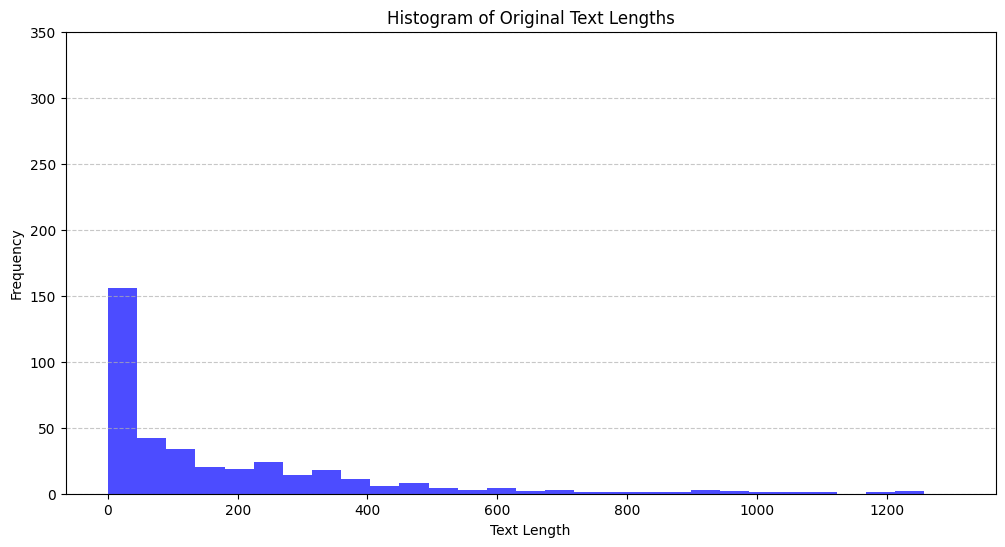

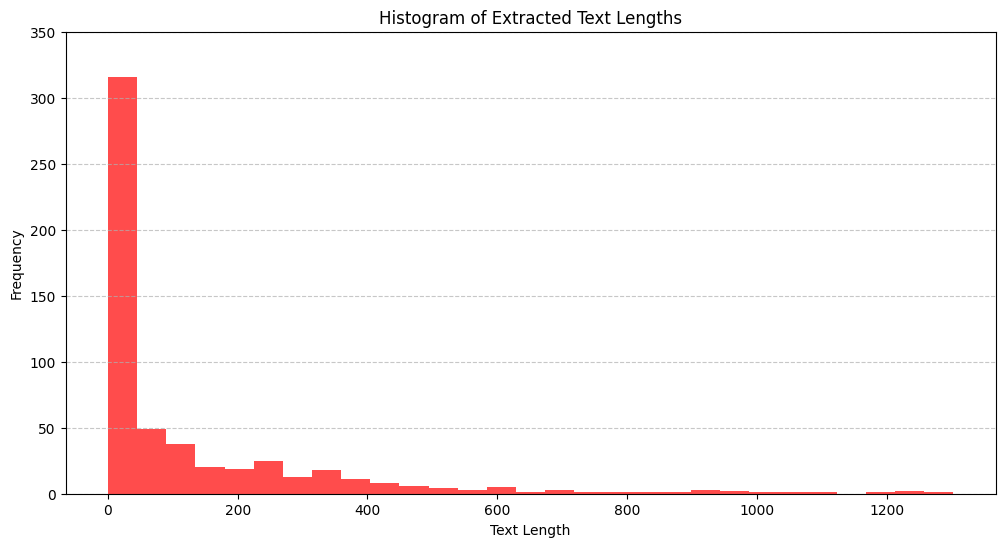

In [81]:
import numpy as np
import matplotlib.pyplot as plt

def histogram_plot(original_texts, extracted_texts):
    """Plot separate histograms for original and extracted text lengths using the same scale and y-axis range."""
    original_lengths = [len(text) for text in original_texts]
    extracted_lengths = [len(text) for text in extracted_texts]
    
    max_length = max(extracted_lengths) if extracted_lengths else 1
    bins = np.linspace(0, max_length, 30)
    max_freq = 350
    
    plt.figure(figsize=(12, 6))
    plt.hist(original_lengths, bins=bins, alpha=0.7, color='b')
    plt.xlabel("Text Length")
    plt.ylabel("Frequency")
    plt.ylim(0, max_freq)
    plt.title("Histogram of Original Text Lengths")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.hist(extracted_lengths, bins=bins, alpha=0.7, color='r')
    plt.xlabel("Text Length")
    plt.ylabel("Frequency")
    plt.ylim(0, max_freq)
    plt.title("Histogram of Extracted Text Lengths")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Generate separate histograms with the same scale and y-axis limit
histogram_plot([item['text'] for item in content_list if item['type'] == 'text'], texts)